In [17]:
import numpy as np
import import_ipynb
import time

In [18]:
# = = = Global Configuration = = =

scale_factor = 100
prob_threshold = 1 / scale_factor
total_dims = 16 # the dimensions of lineitem table
domain_dims = 8 # the dimensions we used and maintain min max for
chunk_size = 100000 # 0.1M 

# base_table_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/9a84f6cd-727f-4f10-ae95-10a0214e10a4-tpc-h-tool/2.18.0_rc2/dbgen/lineitem_'
# table_path = base_table_path + str(scale_factor) + '.tbl'

base_save_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Robust/dataset/lineitem_'
save_path_data = base_save_path + str(scale_factor) + '_' + str(prob_threshold) + '.csv'
save_path_domain = base_save_path + str(scale_factor) + '_' + str(prob_threshold) + '_domains.csv'

# by default, the sampled size always equal to 6M (i.e., using scale factor 1), then for a higher scale factor, we need to divide it
block_size = 1000000 // scale_factor # in original file, 1M rows take approximately 128MB

In [19]:
# = = = Data Loading = = =
dataset = np.genfromtxt(save_path_data, delimiter=',') # the sampled subset
domains = np.genfromtxt(save_path_domain, delimiter=',') # the domain of that scale

# Configuration
# used_dimensions = [1,2] # the second and third dimensions
used_dimensions = [1,2,3] # the second, third and fourth dimensions

dataset = dataset[:,used_dimensions]
domains = domains[used_dimensions]

# array([[1.000000e+00, 6.000000e+08],
#        [1.000000e+00, 2.000000e+07],
#        [1.000000e+00, 1.000000e+06],
#        [1.000000e+00, 7.000000e+00],
#        [1.000000e+00, 5.000000e+01],
#        [9.000500e+02, 1.049485e+05],
#        [0.000000e+00, 1.000000e-01],
#        [0.000000e+00, 8.000000e-02]])

In [21]:
# = = = Query Loading = = =
from QueryGeneration import *

In [23]:
# = = = Query Generation = = =

# Configuration
# total_queries = 100
# random_percentage = 0.20
# maximum_random_range = [int((domains[i,1] - domains[i,0])*0.1) for i in range(len(domains))]
# cluster_amount = 8
# maximum_range_dis = [int((domains[i,1] - domains[i,0])*0.1) for i in range(len(domains))]
# sigmas_percentage = [0.2,0.2]

total_queries = 100
random_percentage = 0.20
maximum_random_range = [int((domains[i,1] - domains[i,0])*0.1) for i in range(len(domains))]
cluster_amount = 8
maximum_range_dis = [int((domains[i,1] - domains[i,0])*0.1) for i in range(len(domains))]
sigmas_percentage = [0.2,0.2,0.2]
dimension_probability = [1.0, 0.8, 0.5]
random_shift = False
return_seperate = True

# COMMENT THIS IF NOT GENERATING QUERIES
mixed_queris = generate_query_with_random(total_queries, random_percentage, domains, maximum_random_range, 
                                          cluster_amount, maximum_range_dis, sigmas_percentage, random_shift, 
                                          return_seperate, dimension_probability)

plot_queries_2d_distribution_and_random(mixed_queris[1], mixed_queris[0], domains)
random_query = mixed_queris[0]
distribution_query = mixed_queris[1]

ValueError: empty range for randrange()

In [6]:
# = = = Query Saving / Loading = = =

# Configuration
query_base_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/NORA/query/'

distribution_path = query_base_path + 'alpha_' + str(int(random_percentage*100)) +'_distribution.csv'
random_path = query_base_path + 'alpha_' + str(int(random_percentage*100)) +'_random.csv'

random_segmentation = int(total_queries * random_percentage / 2)
distribution_segmentation = int(total_queries * (1 - random_percentage) / 2)

### SELECT THIS ONE ###  save the generated queries
# save_query(mixed_queris[0], random_path)
# save_query(mixed_queris[1], distribution_path)
# training_set = np.concatenate((random_query[0:random_segmentation], distribution_query[0:distribution_segmentation]), axis=0)
# testing_set = np.concatenate((random_query[random_segmentation:], distribution_query[distribution_segmentation:]), axis = 0)

### OR THIS ONE ###  load the generated query (if the query is generated from another domain, it should be regenerated!)
distribution_query = load_query(distribution_path)
random_query = load_query(random_path)
training_set = np.concatenate((distribution_query[0:distribution_segmentation], random_query[0:random_segmentation]), axis=0)
testing_set = np.concatenate((distribution_query[distribution_segmentation:], random_query[random_segmentation:]), axis = 0)

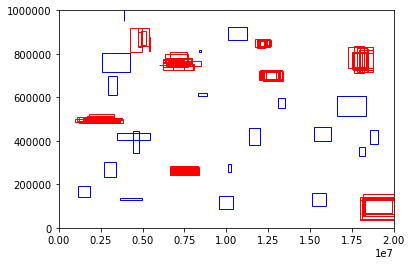

In [7]:
plot_queries_2d_distribution_and_random(distribution_query, random_query, domains)

In [8]:
from Query import *
from Utils import *

importing Jupyter notebook from Query.ipynb
importing Jupyter notebook from Utils.ipynb


In [19]:
# = = = Qd-Tree = = =
from Qd_tree import *

# Configuration
qdtree_partition_base_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/HDFSExperiment/generated_partitions/'
qdtree_path = qdtree_partition_base_path + 'qdtree_partitions_alpha_' + str(int(random_percentage*100))

importing Jupyter notebook from Qd_tree.ipynb


In [50]:
# = = = Qd-Tree = = =
start_time = time.time()

qdtree_kdnodes = Qd_tree_greedy_optimized_approximate(dataset, training_set, domains, block_size, bins=(4000,1000))

end_time = time.time()
print("training time for Qd-Tree (s): ", end_time-start_time)
print('Qd-Tree leaf nodes: ',len(qdtree_kdnodes))

# Qd-Tree Query
Query(testing_set, qdtree_kdnodes, random_percentage)
Query(training_set, qdtree_kdnodes, random_percentage)

# Save Partition
# saved_qdtree_partitions = save_partitions_to_file(qdtree_kdnodes, qdtree_path)

current kdnodes:  1
current inner loop i:  0
lower: [1.0, 1.0]
upper: [9365874.86494534, 1000000.0]
lower: [9365874.86494534, 1.0]
upper: [20000000.0, 1000000.0]
lower: [1.0, 1.0]
upper: [10210558.562524404, 1000000.0]
lower: [10210558.562524404, 1.0]
upper: [20000000.0, 1000000.0]
lower: [1.0, 1.0]
upper: [20000000.0, 583589.6396224549]
lower: [1.0, 583589.6396224549]
upper: [20000000.0, 1000000.0]
lower: [1.0, 1.0]
upper: [20000000.0, 654909.6571656207]
lower: [1.0, 654909.6571656207]
upper: [20000000.0, 1000000.0]
lower: [1.0, 1.0]
upper: [9049780.850675216, 1000000.0]
lower: [9049780.850675216, 1.0]
upper: [20000000.0, 1000000.0]
lower: [1.0, 1.0]
upper: [10335030.270652864, 1000000.0]
lower: [10335030.270652864, 1.0]
upper: [20000000.0, 1000000.0]
lower: [1.0, 1.0]
upper: [20000000.0, 161954.11799648302]
lower: [1.0, 161954.11799648302]
upper: [20000000.0, 1000000.0]
lower: [1.0, 1.0]
upper: [20000000.0, 188121.09120422782]
lower: [1.0, 188121.09120422782]
upper: [20000000.0, 1000

current kdnodes:  2
current inner loop i:  0
lower: [1.0, 1.0]
upper: [9365874.86494534, 504070.03827536746]
lower: [9365874.86494534, 1.0]
upper: [20000000.0, 504070.03827536746]
lower: [1.0, 1.0]
upper: [10210558.562524404, 504070.03827536746]
lower: [10210558.562524404, 1.0]
upper: [20000000.0, 504070.03827536746]
lower: [1.0, 1.0]
upper: [9049780.850675216, 504070.03827536746]
lower: [9049780.850675216, 1.0]
upper: [20000000.0, 504070.03827536746]
lower: [1.0, 1.0]
upper: [10335030.270652864, 504070.03827536746]
lower: [10335030.270652864, 1.0]
upper: [20000000.0, 504070.03827536746]
lower: [1.0, 1.0]
upper: [20000000.0, 161954.11799648302]
lower: [1.0, 161954.11799648302]
upper: [20000000.0, 504070.03827536746]
lower: [1.0, 1.0]
upper: [20000000.0, 188121.09120422782]
lower: [1.0, 188121.09120422782]
upper: [20000000.0, 504070.03827536746]
lower: [1.0, 1.0]
upper: [6743645.377003942, 504070.03827536746]
lower: [6743645.377003942, 1.0]
upper: [20000000.0, 504070.03827536746]
lower:

lower: [1.0, 504070.03827536746]
upper: [7449059.422287792, 1000000.0]
lower: [7449059.422287792, 504070.03827536746]
upper: [20000000.0, 1000000.0]
lower: [1.0, 504070.03827536746]
upper: [20000000.0, 768816.3812734168]
lower: [1.0, 768816.3812734168]
upper: [20000000.0, 1000000.0]
lower: [1.0, 504070.03827536746]
upper: [20000000.0, 857270.0183182892]
lower: [1.0, 857270.0183182892]
upper: [20000000.0, 1000000.0]
lower: [1.0, 504070.03827536746]
upper: [12128486.714824565, 1000000.0]
lower: [12128486.714824565, 504070.03827536746]
upper: [20000000.0, 1000000.0]
lower: [1.0, 504070.03827536746]
upper: [14147442.890263036, 1000000.0]
lower: [14147442.890263036, 504070.03827536746]
upper: [20000000.0, 1000000.0]
lower: [1.0, 504070.03827536746]
upper: [20000000.0, 537603.8297251915]
lower: [1.0, 537603.8297251915]
upper: [20000000.0, 1000000.0]
lower: [1.0, 504070.03827536746]
upper: [20000000.0, 597119.2051061117]
lower: [1.0, 597119.2051061117]
upper: [20000000.0, 1000000.0]
lower: [1

lower: [18155079.538849052, 1.0]
upper: [20000000.0, 302112.6168073254]
lower: [1.0, 1.0]
upper: [7887084.230509165, 302112.6168073254]
lower: [7887084.230509165, 1.0]
upper: [20000000.0, 302112.6168073254]
lower: [1.0, 1.0]
upper: [8398529.769490834, 302112.6168073254]
lower: [8398529.769490834, 1.0]
upper: [20000000.0, 302112.6168073254]
lower: [1.0, 1.0]
upper: [16032007.847123044, 302112.6168073254]
lower: [16032007.847123044, 1.0]
upper: [20000000.0, 302112.6168073254]
lower: [1.0, 1.0]
upper: [17228760.152876955, 302112.6168073254]
lower: [17228760.152876955, 1.0]
upper: [20000000.0, 302112.6168073254]
lower: [1.0, 1.0]
upper: [20000000.0, 6815.476346508731]
lower: [1.0, 6815.476346508731]
upper: [20000000.0, 302112.6168073254]
lower: [1.0, 1.0]
upper: [20000000.0, 77290.52365349127]
lower: [1.0, 77290.52365349127]
upper: [20000000.0, 302112.6168073254]
lower: [1.0, 1.0]
upper: [10429471.077689925, 302112.6168073254]
lower: [10429471.077689925, 1.0]
upper: [20000000.0, 302112.616

lower: [9049780.850675216, 504070.03827536746]
upper: [20000000.0, 654909.6571656207]
lower: [9049780.850675216, 654909.6571656207]
upper: [20000000.0, 1000000.0]
lower: [9049780.850675216, 504070.03827536746]
upper: [10335030.270652864, 1000000.0]
lower: [10335030.270652864, 504070.03827536746]
upper: [20000000.0, 1000000.0]
lower: [9049780.850675216, 504070.03827536746]
upper: [20000000.0, 768816.3812734168]
lower: [9049780.850675216, 768816.3812734168]
upper: [20000000.0, 1000000.0]
lower: [9049780.850675216, 504070.03827536746]
upper: [20000000.0, 857270.0183182892]
lower: [9049780.850675216, 857270.0183182892]
upper: [20000000.0, 1000000.0]
lower: [9049780.850675216, 504070.03827536746]
upper: [12128486.714824565, 1000000.0]
lower: [12128486.714824565, 504070.03827536746]
upper: [20000000.0, 1000000.0]
lower: [9049780.850675216, 504070.03827536746]
upper: [14147442.890263036, 1000000.0]
lower: [14147442.890263036, 504070.03827536746]
upper: [20000000.0, 1000000.0]
lower: [9049780.

upper: [7449059.422287792, 504070.03827536746]
lower: [7449059.422287792, 302112.6168073254]
upper: [10262033.577644669, 504070.03827536746]
lower: [1.0, 302112.6168073254]
upper: [6922200.275151876, 504070.03827536746]
lower: [6922200.275151876, 302112.6168073254]
upper: [10262033.577644669, 504070.03827536746]
lower: [1.0, 302112.6168073254]
upper: [7452684.396994439, 504070.03827536746]
lower: [7452684.396994439, 302112.6168073254]
upper: [10262033.577644669, 504070.03827536746]
lower: [1.0, 302112.6168073254]
upper: [6864070.305323112, 504070.03827536746]
lower: [6864070.305323112, 302112.6168073254]
upper: [10262033.577644669, 504070.03827536746]
lower: [1.0, 302112.6168073254]
upper: [7092769.521248521, 504070.03827536746]
lower: [7092769.521248521, 302112.6168073254]
upper: [10262033.577644669, 504070.03827536746]
lower: [1.0, 302112.6168073254]
upper: [3625622.6001846124, 504070.03827536746]
lower: [3625622.6001846124, 302112.6168073254]
upper: [10262033.577644669, 504070.03827

lower: [10653395.327615317, 302112.6168073254]
upper: [20000000.0, 504070.03827536746]
lower: [10262033.577644669, 302112.6168073254]
upper: [11182254.504984615, 504070.03827536746]
lower: [11182254.504984615, 302112.6168073254]
upper: [20000000.0, 504070.03827536746]
lower: [10262033.577644669, 302112.6168073254]
upper: [20000000.0, 390723.048593151]
lower: [10262033.577644669, 390723.048593151]
upper: [20000000.0, 504070.03827536746]
lower: [10262033.577644669, 302112.6168073254]
upper: [20000000.0, 399808.7879308862]
lower: [10262033.577644669, 399808.7879308862]
upper: [20000000.0, 504070.03827536746]
lower: [10262033.577644669, 302112.6168073254]
upper: [18458968.684295535, 504070.03827536746]
lower: [18458968.684295535, 302112.6168073254]
upper: [20000000.0, 504070.03827536746]
lower: [10262033.577644669, 302112.6168073254]
upper: [12183071.823009396, 504070.03827536746]
lower: [12183071.823009396, 302112.6168073254]
upper: [20000000.0, 504070.03827536746]
lower: [10262033.577644

upper: [11410122.922310075, 697989.3257182407]
lower: [11410122.922310075, 504070.03827536746]
upper: [15472508.66597912, 697989.3257182407]
lower: [9049780.850675216, 504070.03827536746]
upper: [15472508.66597912, 649138.7969379406]
lower: [9049780.850675216, 649138.7969379406]
upper: [15472508.66597912, 697989.3257182407]
lower: [9049780.850675216, 504070.03827536746]
upper: [13232991.825527957, 697989.3257182407]
lower: [13232991.825527957, 504070.03827536746]
upper: [15472508.66597912, 697989.3257182407]
lower: [9049780.850675216, 504070.03827536746]
upper: [14591056.174472043, 697989.3257182407]
lower: [14591056.174472043, 504070.03827536746]
upper: [15472508.66597912, 697989.3257182407]
current inner loop i:  4
lower: [10476023.534890175, 1.0]
upper: [12128486.714824565, 161954.11799648302]
lower: [12128486.714824565, 1.0]
upper: [20000000.0, 161954.11799648302]
lower: [10476023.534890175, 1.0]
upper: [14147442.890263036, 161954.11799648302]
lower: [14147442.890263036, 1.0]
upper

upper: [10262033.577644669, 504070.03827536746]
lower: [3207339.6188845146, 302112.6168073254]
upper: [7772203.929886473, 504070.03827536746]
lower: [7772203.929886473, 302112.6168073254]
upper: [10262033.577644669, 504070.03827536746]
lower: [3207339.6188845146, 302112.6168073254]
upper: [8531529.849948427, 504070.03827536746]
lower: [8531529.849948427, 302112.6168073254]
upper: [10262033.577644669, 504070.03827536746]
lower: [3207339.6188845146, 302112.6168073254]
upper: [8677438.150051573, 504070.03827536746]
lower: [8677438.150051573, 302112.6168073254]
upper: [10262033.577644669, 504070.03827536746]
lower: [3207339.6188845146, 302112.6168073254]
upper: [7737122.662289328, 504070.03827536746]
lower: [7737122.662289328, 302112.6168073254]
upper: [10262033.577644669, 504070.03827536746]
lower: [3207339.6188845146, 302112.6168073254]
upper: [7934335.337710672, 504070.03827536746]
lower: [7934335.337710672, 302112.6168073254]
upper: [10262033.577644669, 504070.03827536746]
lower: [3207

upper: [4519592.308866664, 597119.2051061117]
lower: [1.0, 504070.03827536746]
upper: [1654048.8374917198, 597119.2051061117]
lower: [1654048.8374917198, 504070.03827536746]
upper: [4519592.308866664, 597119.2051061117]
lower: [1.0, 504070.03827536746]
upper: [3100707.16250828, 597119.2051061117]
lower: [3100707.16250828, 504070.03827536746]
upper: [4519592.308866664, 597119.2051061117]
lower: [1.0, 504070.03827536746]
upper: [4519592.308866664, 522991.96172463254]
lower: [1.0, 522991.96172463254]
upper: [4519592.308866664, 597119.2051061117]
lower: [1.0, 504070.03827536746]
upper: [2489644.065725481, 597119.2051061117]
lower: [2489644.065725481, 504070.03827536746]
upper: [4519592.308866664, 597119.2051061117]
lower: [1.0, 504070.03827536746]
upper: [2511271.934274519, 597119.2051061117]
lower: [2511271.934274519, 504070.03827536746]
upper: [4519592.308866664, 597119.2051061117]
lower: [1.0, 504070.03827536746]
upper: [4519592.308866664, 513506.7485646979]
lower: [1.0, 513506.74856469

upper: [6743645.377003942, 504070.03827536746]
current inner loop i:  11
lower: [15472508.66597912, 504070.03827536746]
upper: [20000000.0, 583589.6396224549]
lower: [15472508.66597912, 583589.6396224549]
upper: [20000000.0, 621873.532074591]
lower: [15472508.66597912, 504070.03827536746]
upper: [20000000.0, 537603.8297251915]
lower: [15472508.66597912, 537603.8297251915]
upper: [20000000.0, 621873.532074591]
lower: [15472508.66597912, 504070.03827536746]
upper: [20000000.0, 597119.2051061117]
lower: [15472508.66597912, 597119.2051061117]
upper: [20000000.0, 621873.532074591]
lower: [15472508.66597912, 504070.03827536746]
upper: [19024919.748502757, 621873.532074591]
lower: [19024919.748502757, 504070.03827536746]
upper: [20000000.0, 621873.532074591]
lower: [15472508.66597912, 504070.03827536746]
upper: [20000000.0, 567091.1260759076]
lower: [15472508.66597912, 567091.1260759076]
upper: [20000000.0, 621873.532074591]
lower: [15472508.66597912, 504070.03827536746]
upper: [18458968.6842

lower: [6922200.275151876, 637141.844532404]
upper: [9049780.850675216, 745136.6754669212]
lower: [6922200.275151876, 504070.03827536746]
upper: [9049780.850675216, 682126.155467596]
lower: [6922200.275151876, 682126.155467596]
upper: [9049780.850675216, 745136.6754669212]
lower: [6922200.275151876, 504070.03827536746]
upper: [7887084.230509165, 745136.6754669212]
lower: [7887084.230509165, 504070.03827536746]
upper: [9049780.850675216, 745136.6754669212]
lower: [6922200.275151876, 504070.03827536746]
upper: [8398529.769490834, 745136.6754669212]
lower: [8398529.769490834, 504070.03827536746]
upper: [9049780.850675216, 745136.6754669212]
lower: [6922200.275151876, 504070.03827536746]
upper: [9049780.850675216, 724734.3078556365]
lower: [6922200.275151876, 724734.3078556365]
upper: [9049780.850675216, 745136.6754669212]
lower: [6922200.275151876, 504070.03827536746]
upper: [7479923.672752388, 745136.6754669212]
lower: [7479923.672752388, 504070.03827536746]
upper: [9049780.850675216, 74

upper: [20000000.0, 1000000.0]
lower: [10210558.562524404, 834605.2344840775]
upper: [10476023.534890175, 1000000.0]
lower: [10476023.534890175, 834605.2344840775]
upper: [20000000.0, 1000000.0]
lower: [10210558.562524404, 834605.2344840775]
upper: [11321296.729403358, 1000000.0]
lower: [11321296.729403358, 834605.2344840775]
upper: [20000000.0, 1000000.0]
lower: [10210558.562524404, 834605.2344840775]
upper: [10653395.327615317, 1000000.0]
lower: [10653395.327615317, 834605.2344840775]
upper: [20000000.0, 1000000.0]
lower: [10210558.562524404, 834605.2344840775]
upper: [11182254.504984615, 1000000.0]
lower: [11182254.504984615, 834605.2344840775]
upper: [20000000.0, 1000000.0]
lower: [10210558.562524404, 834605.2344840775]
upper: [20000000.0, 861410.6908890606]
lower: [10210558.562524404, 861410.6908890606]
upper: [20000000.0, 1000000.0]
lower: [10210558.562524404, 834605.2344840775]
upper: [18458968.684295535, 1000000.0]
lower: [18458968.684295535, 834605.2344840775]
upper: [20000000

upper: [14710233.972233512, 302112.6168073254]
lower: [10476023.534890175, 161954.11799648302]
upper: [12128486.714824565, 302112.6168073254]
lower: [12128486.714824565, 161954.11799648302]
upper: [14710233.972233512, 302112.6168073254]
lower: [10476023.534890175, 161954.11799648302]
upper: [14147442.890263036, 302112.6168073254]
lower: [14147442.890263036, 161954.11799648302]
upper: [14710233.972233512, 302112.6168073254]
lower: [10476023.534890175, 161954.11799648302]
upper: [11269000.287020622, 302112.6168073254]
lower: [11269000.287020622, 161954.11799648302]
upper: [14710233.972233512, 302112.6168073254]
lower: [10476023.534890175, 161954.11799648302]
upper: [14710233.972233512, 174304.0189784305]
lower: [10476023.534890175, 174304.0189784305]
upper: [14710233.972233512, 302112.6168073254]
lower: [10476023.534890175, 161954.11799648302]
upper: [11296521.52601366, 302112.6168073254]
lower: [11296521.52601366, 161954.11799648302]
upper: [14710233.972233512, 302112.6168073254]
lower:

lower: [6743645.377003942, 476441.83702985366]
upper: [8398529.769490834, 504070.03827536746]
lower: [6743645.377003942, 302112.6168073254]
upper: [8398529.769490834, 338540.4477010851]
lower: [6743645.377003942, 338540.4477010851]
upper: [8398529.769490834, 504070.03827536746]
lower: [6743645.377003942, 302112.6168073254]
upper: [8398529.769490834, 437645.5410257892]
lower: [6743645.377003942, 437645.5410257892]
upper: [8398529.769490834, 504070.03827536746]
lower: [6743645.377003942, 302112.6168073254]
upper: [8398529.769490834, 326894.4239294584]
lower: [6743645.377003942, 326894.4239294584]
upper: [8398529.769490834, 504070.03827536746]
lower: [6743645.377003942, 302112.6168073254]
upper: [8398529.769490834, 405530.746508227]
lower: [6743645.377003942, 405530.746508227]
upper: [8398529.769490834, 504070.03827536746]
lower: [6743645.377003942, 302112.6168073254]
upper: [8398529.769490834, 359827.1741325851]
lower: [6743645.377003942, 359827.1741325851]
upper: [8398529.769490834, 504

upper: [18195547.453324668, 727523.2030620594]
lower: [12128486.714824565, 727523.2030620594]
upper: [18195547.453324668, 834605.2344840775]
lower: [12128486.714824565, 697989.3257182407]
upper: [13232991.825527957, 834605.2344840775]
lower: [13232991.825527957, 697989.3257182407]
upper: [18195547.453324668, 834605.2344840775]
lower: [12128486.714824565, 697989.3257182407]
upper: [14591056.174472043, 834605.2344840775]
lower: [14591056.174472043, 697989.3257182407]
upper: [18195547.453324668, 834605.2344840775]
current inner loop i:  40
lower: [7452684.396994439, 158920.69023181844]
upper: [9049780.850675216, 188121.09120422782]
lower: [7452684.396994439, 188121.09120422782]
upper: [9049780.850675216, 302112.6168073254]
lower: [7452684.396994439, 158920.69023181844]
upper: [7772203.929886473, 302112.6168073254]
lower: [7772203.929886473, 158920.69023181844]
upper: [9049780.850675216, 302112.6168073254]
lower: [7452684.396994439, 158920.69023181844]
upper: [8531529.849948427, 302112.616

upper: [10476023.534890175, 302112.6168073254]
current inner loop i:  57
lower: [1.0, 888732.1148926]
upper: [3625622.6001846124, 1000000.0]
lower: [3625622.6001846124, 888732.1148926]
upper: [4519592.308866664, 1000000.0]
lower: [1.0, 888732.1148926]
upper: [2399512.35316619, 1000000.0]
lower: [2399512.35316619, 888732.1148926]
upper: [4519592.308866664, 1000000.0]
lower: [1.0, 888732.1148926]
upper: [3928407.64683381, 1000000.0]
lower: [3928407.64683381, 888732.1148926]
upper: [4519592.308866664, 1000000.0]
lower: [1.0, 888732.1148926]
upper: [1542546.3811154854, 1000000.0]
lower: [1542546.3811154854, 888732.1148926]
upper: [4519592.308866664, 1000000.0]
lower: [1.0, 888732.1148926]
upper: [3207339.6188845146, 1000000.0]
lower: [3207339.6188845146, 888732.1148926]
upper: [4519592.308866664, 1000000.0]
lower: [1.0, 888732.1148926]
upper: [4519592.308866664, 964126.094114106]
lower: [1.0, 964126.094114106]
upper: [4519592.308866664, 1000000.0]
lower: [1.0, 888732.1148926]
upper: [16434

In [51]:
# Query(testing_set[0:1], qdtree_kdnodes)

In [14]:
# = = = NORA = = =
from NORA import *

# Configuration
data_threshold = block_size
query_threshold = 2
hist_m, hist_n = 4000, 1000
nora_partition_base_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/HDFSExperiment/generated_partitions/'
nora_path = nora_partition_base_path + 'nora_partitions_alpha_' + str(int(random_percentage*100))

In [15]:
# = = = NORA = = =
start_time = time.time()

# nora_kdnodes, kdnode_dict, accu_count_list, kdnode_idx, query_idx, query_hist = LKD_Robust_Initialization(
#     dataset, training_set, domains, data_threshold, query_threshold, hist_m, hist_n, random_query_percentage = 0.5)

# nora_kdnodes, kdnode_dict, accu_count_list, kdnode_idx, query_idx, query_hist = LKD_Robust_Initialization_V2(
#     dataset, training_set, domains, data_threshold, query_threshold, hist_m, hist_n, random_query_percentage = 0.5)

nora_kdnodes, kdnode_dict, accu_count_list, kdnode_idx, query_idx, query_hist = LKD_Robust_Initialization_V3(
    dataset, training_set, domains, data_threshold, query_threshold, hist_m, hist_n, random_query_percentage = 0.5)

# ==============================================================================================================

# # temp only consider the partition formed by filtered distribution query
# nora_kdnodes, kdnode_dict, accu_count_list, kdnode_idx, query_idx, query_hist = LKD_Robust_Initialization_sub(
#     dataset, training_set, domains, data_threshold, query_threshold, hist_m, hist_n, random_query_percentage = 0.5)

#temp2 only consider the partition formed by filtered distribution query -- using the latest classification
# nora_kdnodes, kdnode_dict, accu_count_list, kdnode_idx, query_idx, query_hist = LKD_Robust_Initialization_sub_V2(
#     dataset, training_set, domains, data_threshold, query_threshold, hist_m, hist_n, random_query_percentage = 0.5)

# temp3 only consider the partition formed by filtered distribution query, then apply AKD on the bounded filtered queries
# nora_kdnodes, kdnode_dict, accu_count_list, kdnode_idx, query_idx, query_hist = LKD_Robust_Initialization_sub_V3(
#     dataset, training_set, domains, data_threshold, query_threshold, hist_m, hist_n, random_query_percentage = 0.5)

end_time = time.time()
print("training time for NORA (s): ", end_time-start_time)
print('NORA leaf nodes: ',len(nora_kdnodes))

# NORA Query
Query(testing_set, nora_kdnodes, random_percentage)
Query(training_set, nora_kdnodes, random_percentage)

# Save Partition
# saved_nora_partitions = save_partitions_to_file(nora_kdnodes, nora_path)

= = = current try split kdnode: [[1.00000e+00 2.00000e+07]
 [1.00000e+00 1.24919e+05]]
= = = current try split kdnode: [[1.000000e+00 5.186234e+06]
 [1.249190e+05 1.874940e+05]]
= = = current try split kdnode: [[5186234. 7903438.]
 [ 124919.  187494.]]
= = = current try split kdnode: [[ 7903438.         10473116.38395241]
 [  124919.           187494.        ]]
= = = current try split kdnode: [[7903438.         9197197.93524863]
 [ 124919.          187494.        ]]
= = = current try split kdnode: [[ 9197197.93526863 10473116.38395241]
 [  124919.           187494.        ]]
= = = current try split kdnode: [[10473116.38395241 20000000.        ]
 [  124919.           187494.        ]]
= = = current try split kdnode: [[10473116.38395241 11321296.72939336]
 [  124919.           187494.        ]]
= = = current try split kdnode: [[11321296.72941336 20000000.        ]
 [  124919.           187494.        ]]
= = = current try split kdnode: [[1.00000e+00 2.00000e+07]
 [1.87494e+05 2.49859e+05]

= = = current try split kdnode: [[10001915. 20000000.]
 [  873258.  1000000.]]
training time for NORA (s):  15.712969064712524
NORA leaf nodes:  497
Query 0  Cost:  82049  Intersected Partitions: [42, 43, 46, 47, 58, 59, 62]
Query 1  Cost:  31320  Intersected Partitions: [203, 204, 205]
Query 2  Cost:  81777  Intersected Partitions: [305, 307, 309, 310, 311, 312]
Query 3  Cost:  14116  Intersected Partitions: [401]
Query 4  Cost:  46886  Intersected Partitions: [144, 155, 156, 159]
Query 5  Cost:  85499  Intersected Partitions: [305, 307, 311, 312, 313, 341]
Query 6  Cost:  29771  Intersected Partitions: [370, 371]
Query 7  Cost:  57834  Intersected Partitions: [320, 321, 322, 323]
Query 8  Cost:  65673  Intersected Partitions: [193, 194, 195, 203, 205]
Query 9  Cost:  35164  Intersected Partitions: [144, 155, 156]
Query 10  Cost:  23458  Intersected Partitions: [78, 79]
Query 11  Cost:  69747  Intersected Partitions: [314, 315, 320, 321]
Query 12  Cost:  20880  Intersected Partitions:

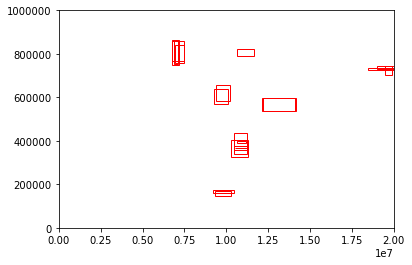

In [11]:
filtered_queries, query_hist = filter_distribution_query_V2(training_set, domains, hist_m, hist_n, query_threshold)
plot_queries_2d_distribution_and_random(filtered_queries, [], domains)

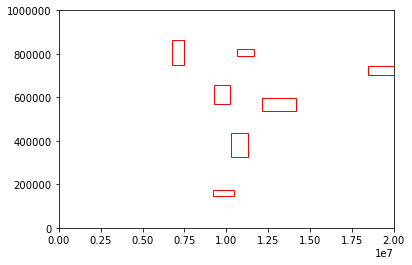

In [12]:
bounded_query = query_bounding(filtered_queries)
plot_queries_2d_distribution_and_random(bounded_query, [], domains)

In [58]:
# = = = KD-Tree = = =

kdtree_partition_base_path = 'C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/HDFSExperiment/generated_partitions/'
kdtree_path = kdtree_partition_base_path + 'kdtree_partitions_alpha_' + str(int(random_percentage*100))

current_dim = 0
data_threshold = block_size
root_node = [domains, len(dataset), 0, -1, -1, -1] # sub_domains, len(sub_dataset1), id, parent_id, left_child_id, right_child_id
kdnode_dict = {}
accu_count_list = [0]

kdtree_kdnodes = KDPartition(dataset, current_dim, data_threshold, root_node, kdnode_dict, accu_count_list)
# save_partitions_to_file(kdtree_kdnodes, kdtree_path)

print("KDTree leaf nodes:", len(kdtree_kdnodes))
Query(testing_set, kdtree_kdnodes, random_percentage)
Query(training_set, kdtree_kdnodes, random_percentage)

In [13]:
# # = = = Rtree = = =

# from RtreeBulkloading import *

# data_threshold = block_size
# BulkLoadMBRs = GenerateRtreePartitionUsingBulkLoading(dataset, maximum_capacity = data_threshold)
# print(BulkLoadMBRs)

# #np.savetxt('C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Legacy/data/RtreeBulkLoadPartitions.csv', BulkLoadMBRs, delimiter=',')
# rtree_kdnodes = PartitionFormalization(BulkLoadMBRs)
# # print(rtree_partitions.shape)
# print(len(rtree_kdnodes))
# # RTree Query:
# Query(testing_set, rtree_kdnodes)

In [10]:
# = = = Visualization = = =
from Utils import *

importing Jupyter notebook from Utils.ipynb


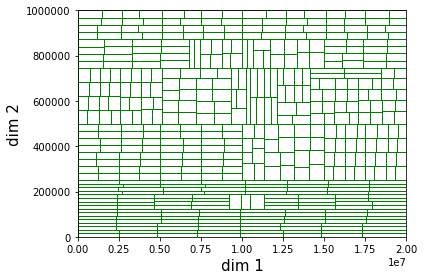

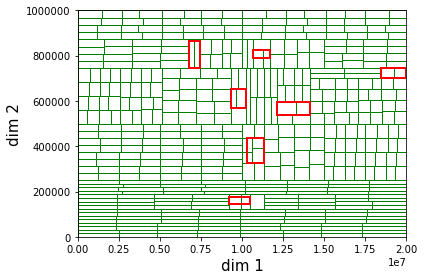

In [15]:
# for bounded query
# visualize_kdnodes_and_query_2(nora_kdnodes, distribution_query[0:distribution_segmentation], random_query[0:random_segmentation], domains)
# visualize_kdnodes_and_query_2(nora_kdnodes, filtered_queries, [], domains)
visualize_kdnodes_and_query_2(nora_kdnodes, [], [], domains)
visualize_kdnodes_and_query_2(nora_kdnodes, bounded_query, [], domains)

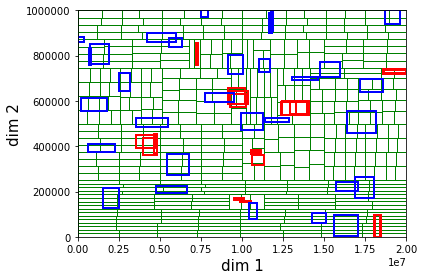

In [14]:
# testing set, Qd-Tree
# visualize_kdnodes_and_query_2(qdtree_kdnodes, distribution_query[distribution_segmentation:], random_query[random_segmentation:], domains) 
# testing set, NORA
visualize_kdnodes_and_query_2(nora_kdnodes, distribution_query[distribution_segmentation:], random_query[random_segmentation:], domains)
# testing set, KDTree
# visualize_kdnodes_and_query_2(kdtree_kdnodes, distribution_query[distribution_segmentation:], random_query[random_segmentation:], domains)

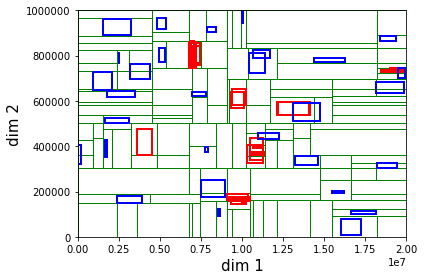

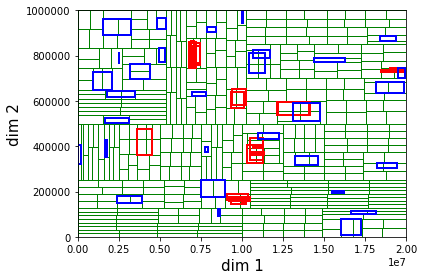

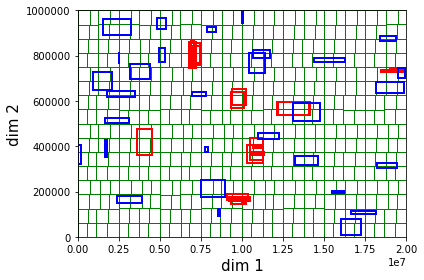

In [63]:
# training set, Qd-Tree
visualize_kdnodes_and_query_2(qdtree_kdnodes, distribution_query[0:distribution_segmentation], random_query[0:random_segmentation], domains) 
# training set, NORA
visualize_kdnodes_and_query_2(nora_kdnodes, distribution_query[0:distribution_segmentation], random_query[0:random_segmentation], domains)
# training set, KDTree
visualize_kdnodes_and_query_2(kdtree_kdnodes, distribution_query[0:distribution_segmentation], random_query[0:random_segmentation], domains)

In [64]:
# consider the border of some queries?